# Summary of the Project

In [23]:
# Import required libraries
# Pyspark and pandas
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import lit, when
#from pyspark.sql.functions import *
from pyspark.sql.functions import year
from pyspark.sql.functions import col, concat_ws
from pyspark.sql.functions import min, max
import pandas as pd

# Visualisation libraries
import seaborn as sns
from matplotlib import pyplot as plt

In [24]:
# Create a spark session
spark = (
    SparkSession.builder.appName("BNPL Project")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

## ETL Script

The ETL script will carry out all the preprocessing, category assignment and incorporation of the external dataset. It will output a single parquet file "process_data.parquet".

In [25]:
# Read output file of ETL script
sdf = spark.read.parquet("../data/curated/process_data.parquet/")

A sample instance of the combined dataset is shown below:

In [26]:
# show an instance of the dataset
sdf.show(1, vertical=True)

-RECORD 0----------------------------------------------------
 merchant_abn                         | 31585975447          
 consumer_id                          | 1656                 
 user_id                              | 8913                 
 dollar_value                         | 51.28                
 order_id                             | 00001f53-b987-4b4... 
 order_datetime                       | 2021-07-24           
 state                                | NSW                  
 postcode                             | 1163                 
 gender                               | Male                 
 merchant_name                        | Dolor Dapibus Gra... 
 tag                                  | digital goods: bo... 
 revenue                              | b                    
 rate                                 | 0.0312               
 category                             | retail_and_wholes... 
 subcategory                          | household_goods_r... 
 merchan

## Categories of the merchants

The merchants is divided into 5 different categories based on their tags:
1. Rental Hiring and Real Estate
2. Retail and Wholesale Trade
3. Agriculture
4. Arts and Recreation
5. Info, Media and Telecommunications

This is done to be able to rank merchants from different industries separately.
The number of merchants and transactions for each category is shown below.

In [27]:
# calculate number of transactions per category
transactionpd = sdf.groupBy("category").count().toPandas()

# calculate number of merchants per category
merchantpd = sdf.groupBy("category").agg(F.countDistinct("merchant_abn")).toPandas()

# format and show table
df = transactionpd.merge(merchantpd, on="category")
df = df.rename(columns = {"count": "number of transactions", "count(merchant_abn)": "number of merchants"})
df

,category,number of transactions,number of merchants
0,retail_and_wholesale_trade,11321695,2956
1,rental_hiring_and_real_estate,34040,134
2,arts_and_recreation,20101,112
3,others,244335,164
4,info_media_and_telecommunications,1886393,655


## Fraud Data

To identify fraudulent transactions, Gradient-Boosted Tree Regression is used. The user and merchant fraud probabilities given is used to train a model to predict the fraud probabilities of the remaining transactions. The features used in the model are the dollar value, gender of customer, revenue level and take rate of each transaction. After predicting, the outliers of user fraud probabilities and merchant fraud probabilities are identified. Transactions with user and merchant fraud probabilities which are both considered as outliers will be considered fraudulent. They are then removed from the dataset.

The user fraud detection model has a root mean-squared error of 0.0806, and the merchant fraud detection model has a root mean-squared error of 0.0256. The root mean-squared error measures how well the model predicts values, and a low mean squared-error shows that the model fits well. Since these values are very low, the model performs well and is therefore chosen to be used for the project.

The fraud detection model is included in the ETL script.

## Outlier analysis

Outlier analysis is done on the dollar value of each transaction.

To ensure that transactions of similar scale are compared, the largest merchant category, retail and wholesale trade, is further divided into 5 subcategories, which are: food, household goods, clothing/footwear/personal accessory, department stores and others.

Outlier analysis is also done on the population and income values from the external dataset.

In [28]:
# outlier detection
dataset = sdf
category = dataset.select('category').distinct()

# separate by category
for cat in category.collect():
    subset = dataset.filter(F.col("category") == cat[0])

    # if category is retail and wholesale trade, carry out outlier detection on each subcategory
    if (cat == 'retail_and_wholesale_trade'):
        subcategory = subset.select('subcategory').distinct()
        for subcat in subcategory.collect():
            sub = subset.filter(F.col("subcategory") == subcat[0])

            # calculate quantiles
            q3, q1 = sub.approxQuantile('dollar_value', [0.75, 0.25], 0) 
            iqr = q3 - q1
            min = q1 - 1.5*iqr
            max = q3 + 1.5*iqr

            # create a boolean column to show if a transaction is an outlier
            if ('isOutlier' in dataset.columns):
                dataset = dataset.withColumn('isOutlier', 
                            when((dataset.subcategory == subcat[0]) & (dataset.dollar_value >= min) & (dataset.dollar_value <= max), lit('False'))\
                            .when((dataset.subcategory == subcat[0]), lit('True'))
                            .otherwise(dataset.isOutlier))
            else:
                dataset = dataset.withColumn('isOutlier', 
                            when((dataset.subcategory == subcat[0]) & (dataset.dollar_value >= min) & (dataset.dollar_value <= max), lit('False'))\
                            .when((dataset.subcategory == subcat[0]), lit('True')))
    else:
        # calculate quantiles
        q3, q1 = subset.approxQuantile('dollar_value', [0.75, 0.25], 0) 
        iqr = q3 - q1
        min = q1 - 1.5*iqr
        max = q3 + 1.5*iqr

        # create a boolean column to show if a transaction is an outlier
        if ('isOutlier' in dataset.columns):
            dataset = dataset.withColumn('isOutlier', 
                        when((dataset.category == cat[0]) & (dataset.dollar_value >= min) & (dataset.dollar_value <= max), lit('False'))\
                        .when((dataset.category == cat[0]), lit('True'))
                        .otherwise(dataset.isOutlier))
        else:
            dataset = dataset.withColumn('isOutlier', 
                        when((dataset.category == cat[0]) & (dataset.dollar_value >= min) & (dataset.dollar_value <= max), lit('False'))\
                        .when((dataset.category == cat[0]), lit('True')))

dataset_wo_outliers = dataset.filter(F.col("isOutlier") == 'False')

In [29]:
# Population Outlier Detection
population_q3, population_q1 = dataset_wo_outliers.approxQuantile('estimated_region_population_2021_sum', [0.75, 0.25], 0) 
population_iqr = population_q3 - population_q1
population_min = population_q1 - 1.5*population_iqr
population_max = population_q3 + 1.5*population_iqr

# Income Outlier Detection
income_q3, income_q1 = dataset_wo_outliers.approxQuantile('mean_earnings_2018-19_avg', [0.75, 0.25], 0) 
income_iqr = income_q3 - income_q1
income_min = income_q1 - 1.5*income_iqr
income_max = income_q3 + 1.5*income_iqr


final_dataset = dataset_wo_outliers.filter(((F.col("estimated_region_population_2021_sum") >= population_min) & 
                                            (F.col("estimated_region_population_2021_sum") <= population_max)) | 
                                            ((F.col("mean_earnings_2018-19_avg") >= income_min) & 
                                            (F.col("mean_earnings_2018-19_avg") <= income_max)))
final_dataset = final_dataset.withColumn('order_datetime', F.to_timestamp('order_datetime'))

## Visualisations

Some plots are made to show the relationships between features. These are done with the datasets without outliers to improve accuracy.

### 1. Sum of dollar value for each category gender wise

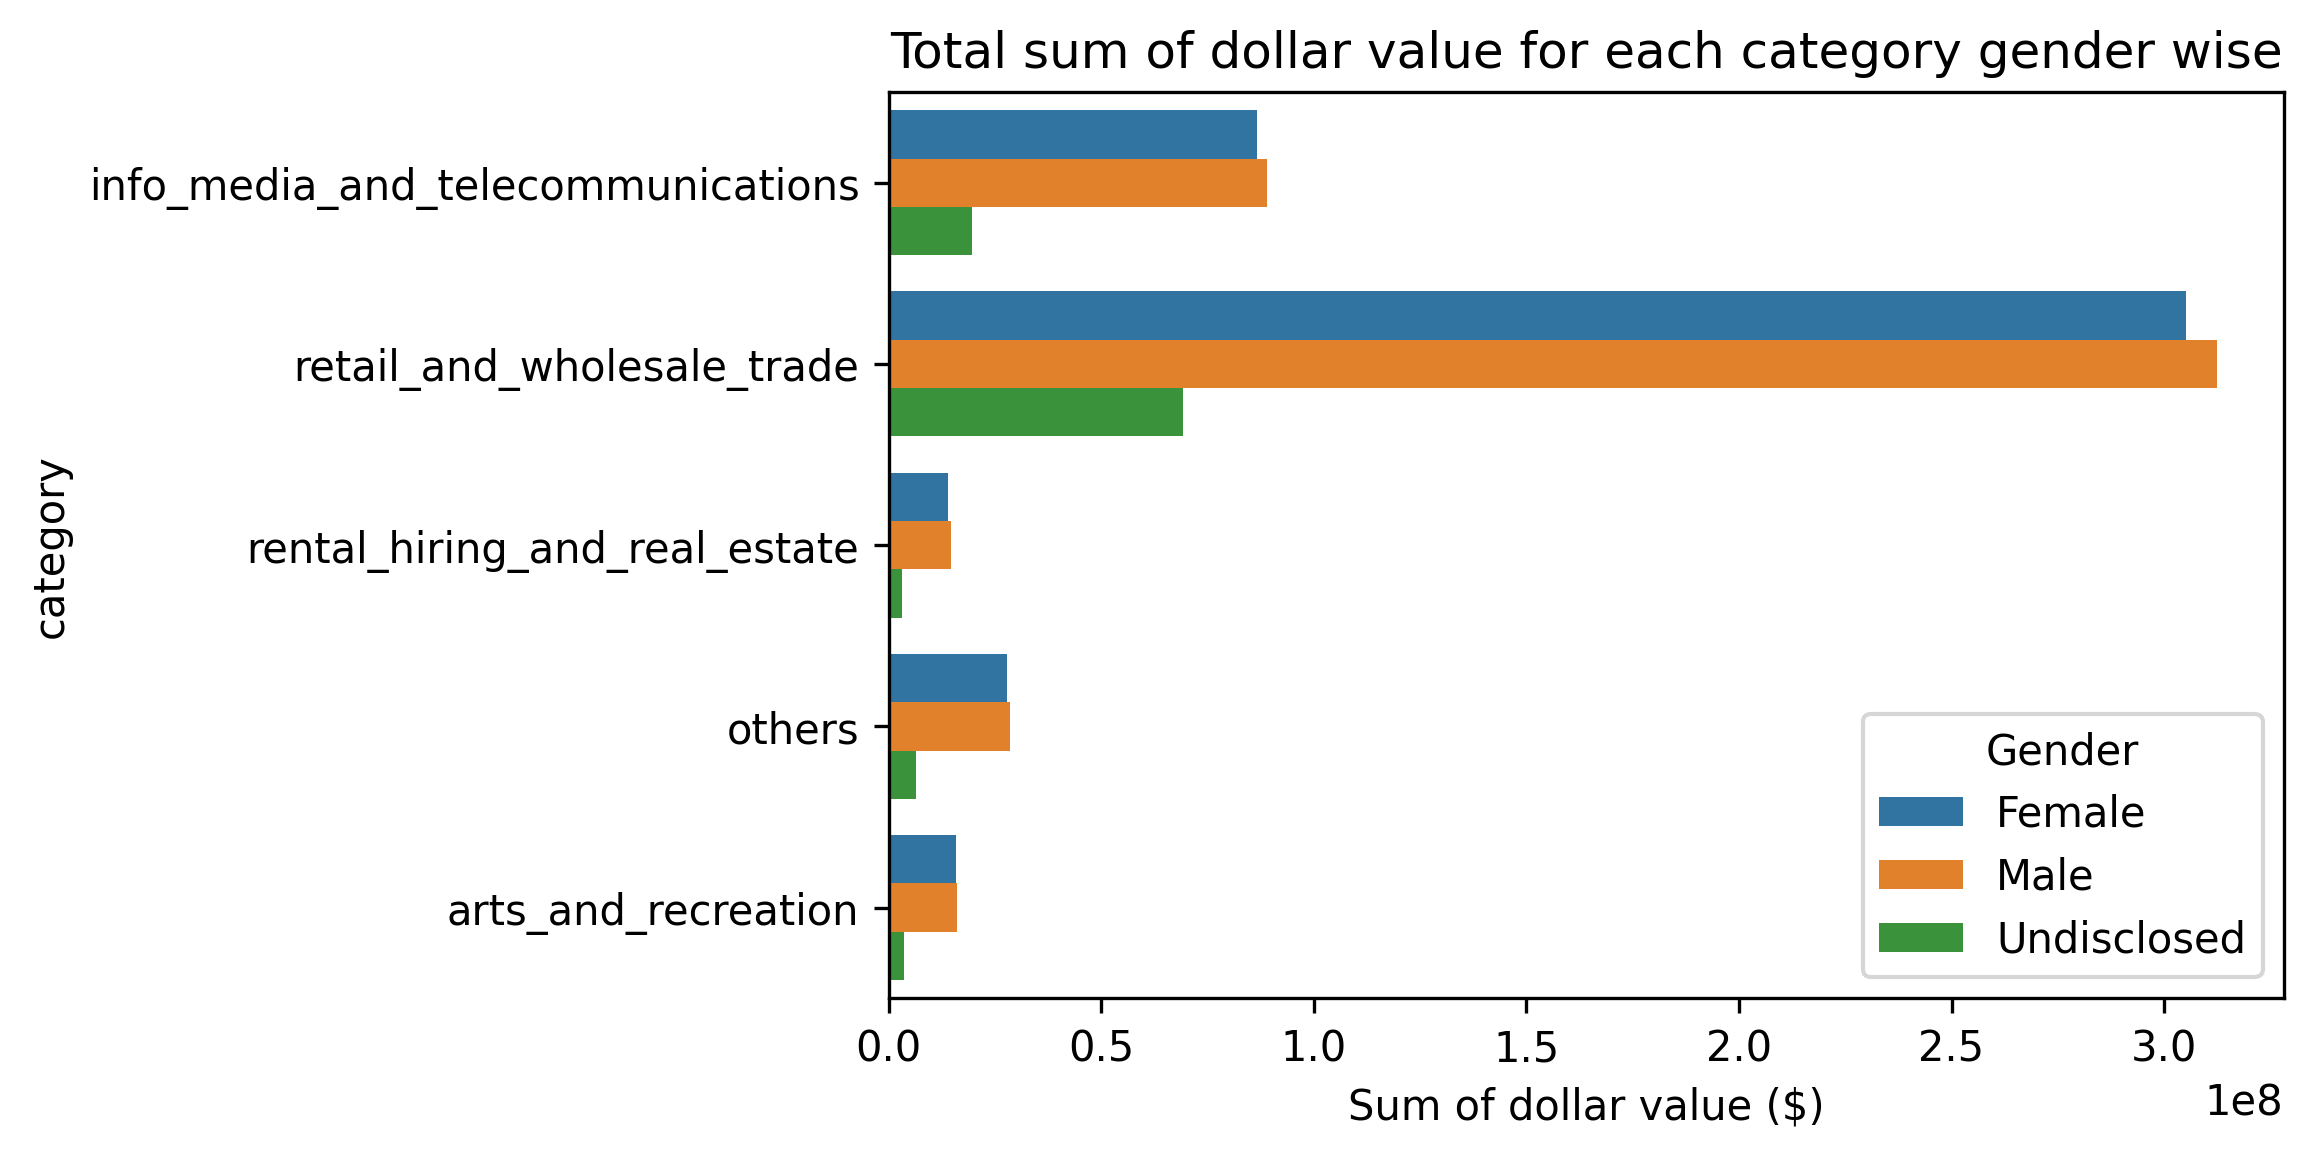

In [30]:
# set dpi of plots
plt.rcParams['figure.dpi'] = 300

# aggregrate 
gender_category = final_dataset.groupBy('category', 'gender').sum('dollar_value')

# plot results
sns.barplot(data= gender_category.toPandas(), x= 'sum(dollar_value)', y="category", hue="gender")
plt.title('Total sum of dollar value for each category gender wise')
plt.xlabel('Sum of dollar value ($)')
plt.legend(loc='lower right', title='Gender')

### 2. Sum of dollar value for each subcategory gender wise

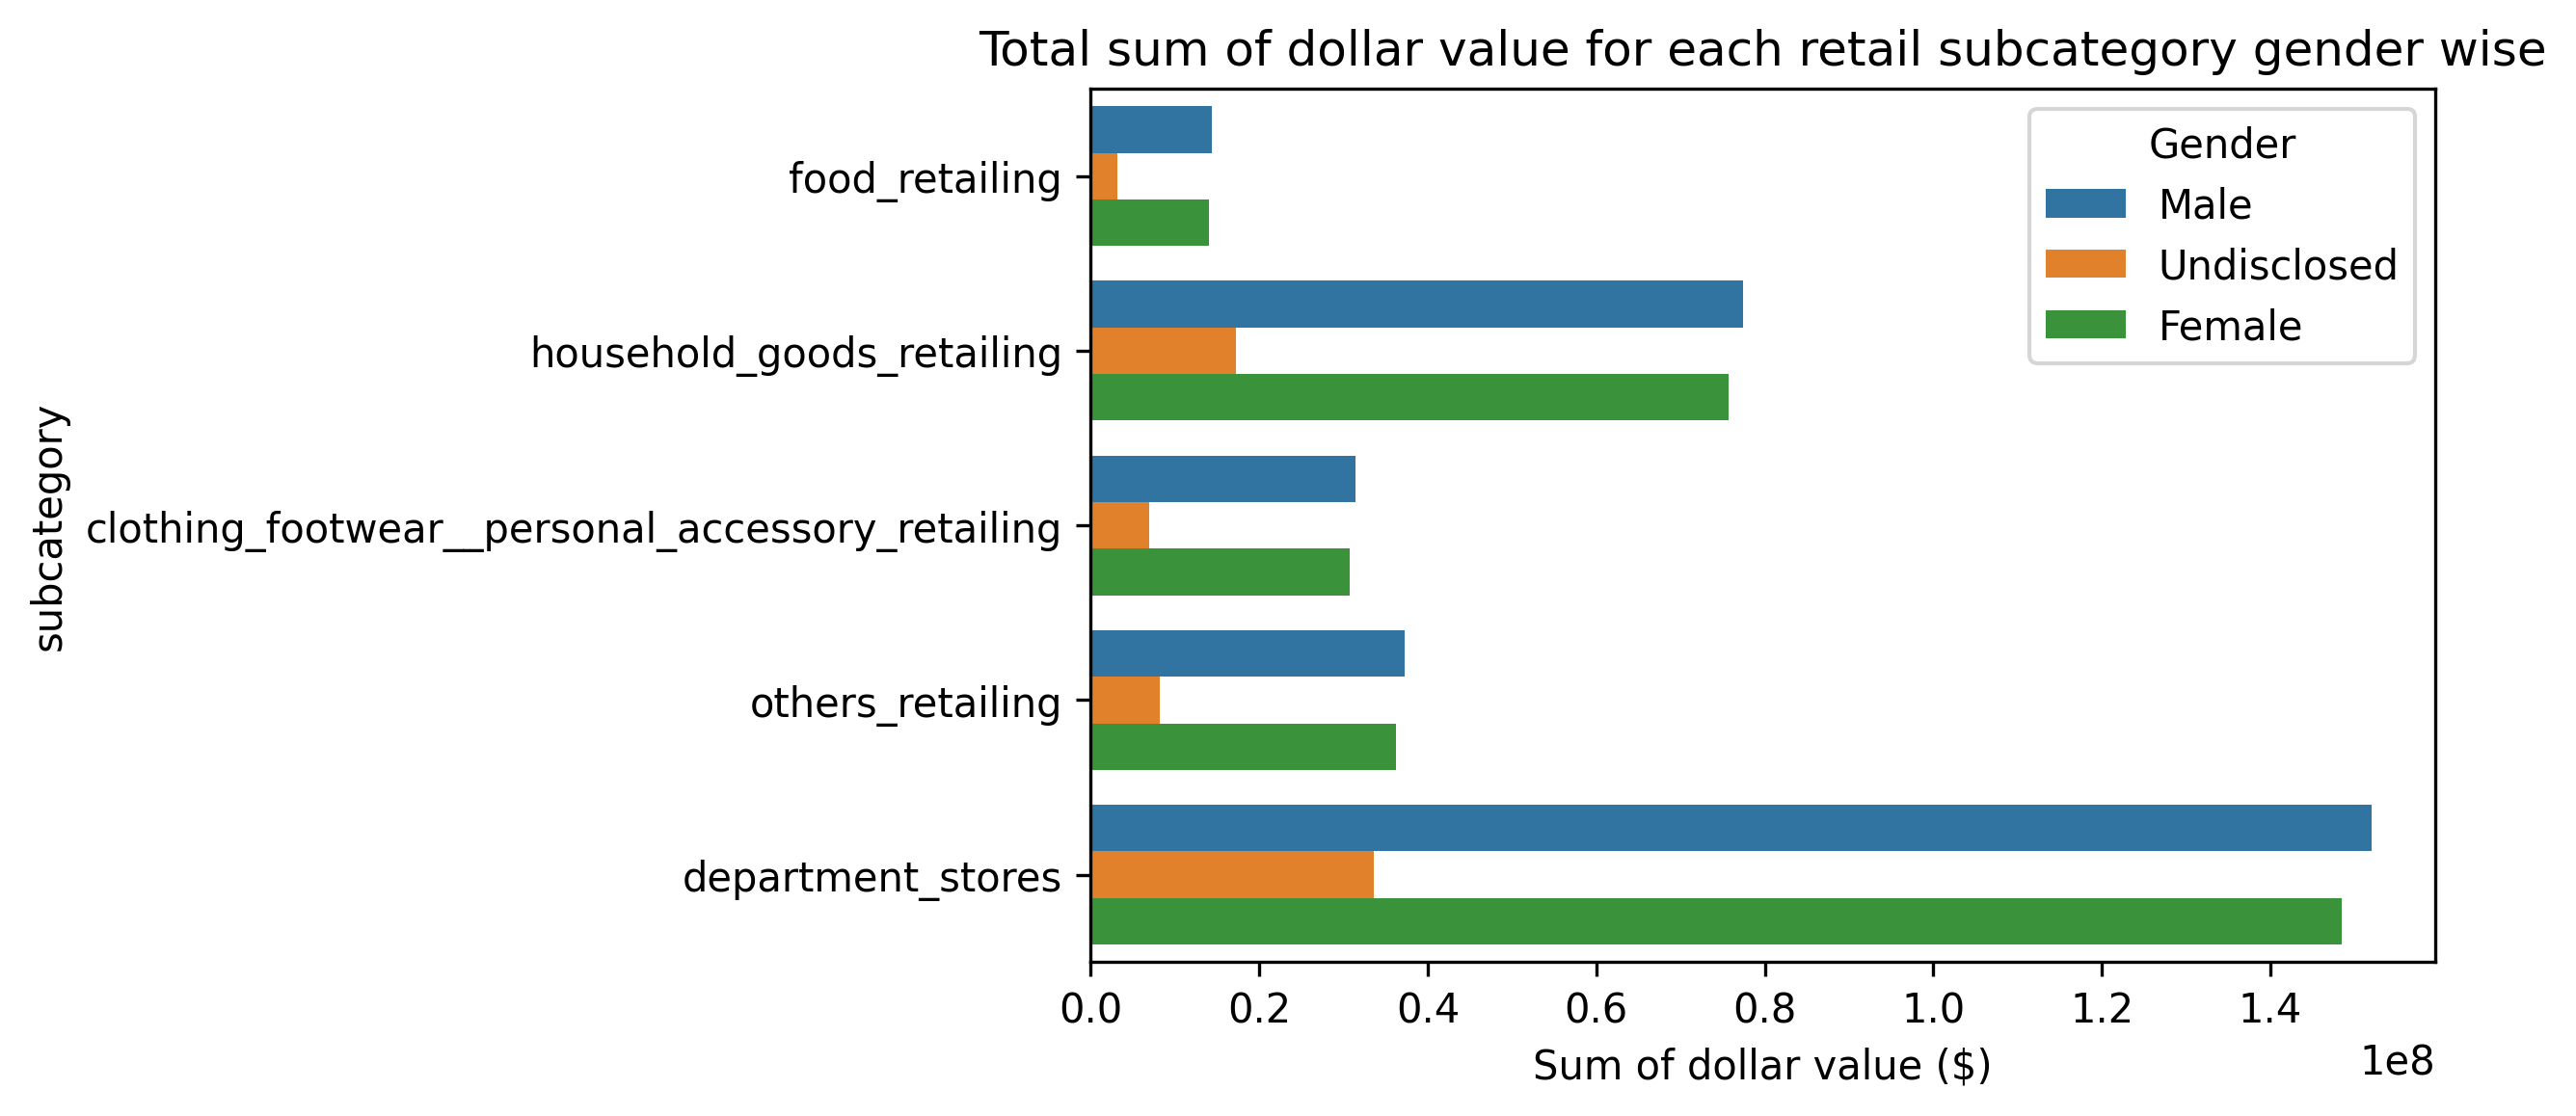

In [31]:
# aggregate
gender_subcategory = final_dataset.groupBy('subcategory', 'gender').sum('dollar_value')

# plot results
sns.barplot(data= gender_subcategory.toPandas(), x= 'sum(dollar_value)', y="subcategory", hue="gender")
plt.title('Total sum of dollar value for each retail subcategory gender wise')
plt.xlabel('Sum of dollar value ($)')
plt.legend(loc='upper right', title='Gender')

### 3. Monthly sum of dollar value for each category

Text(0, 0.5, 'Sum of dollar value')

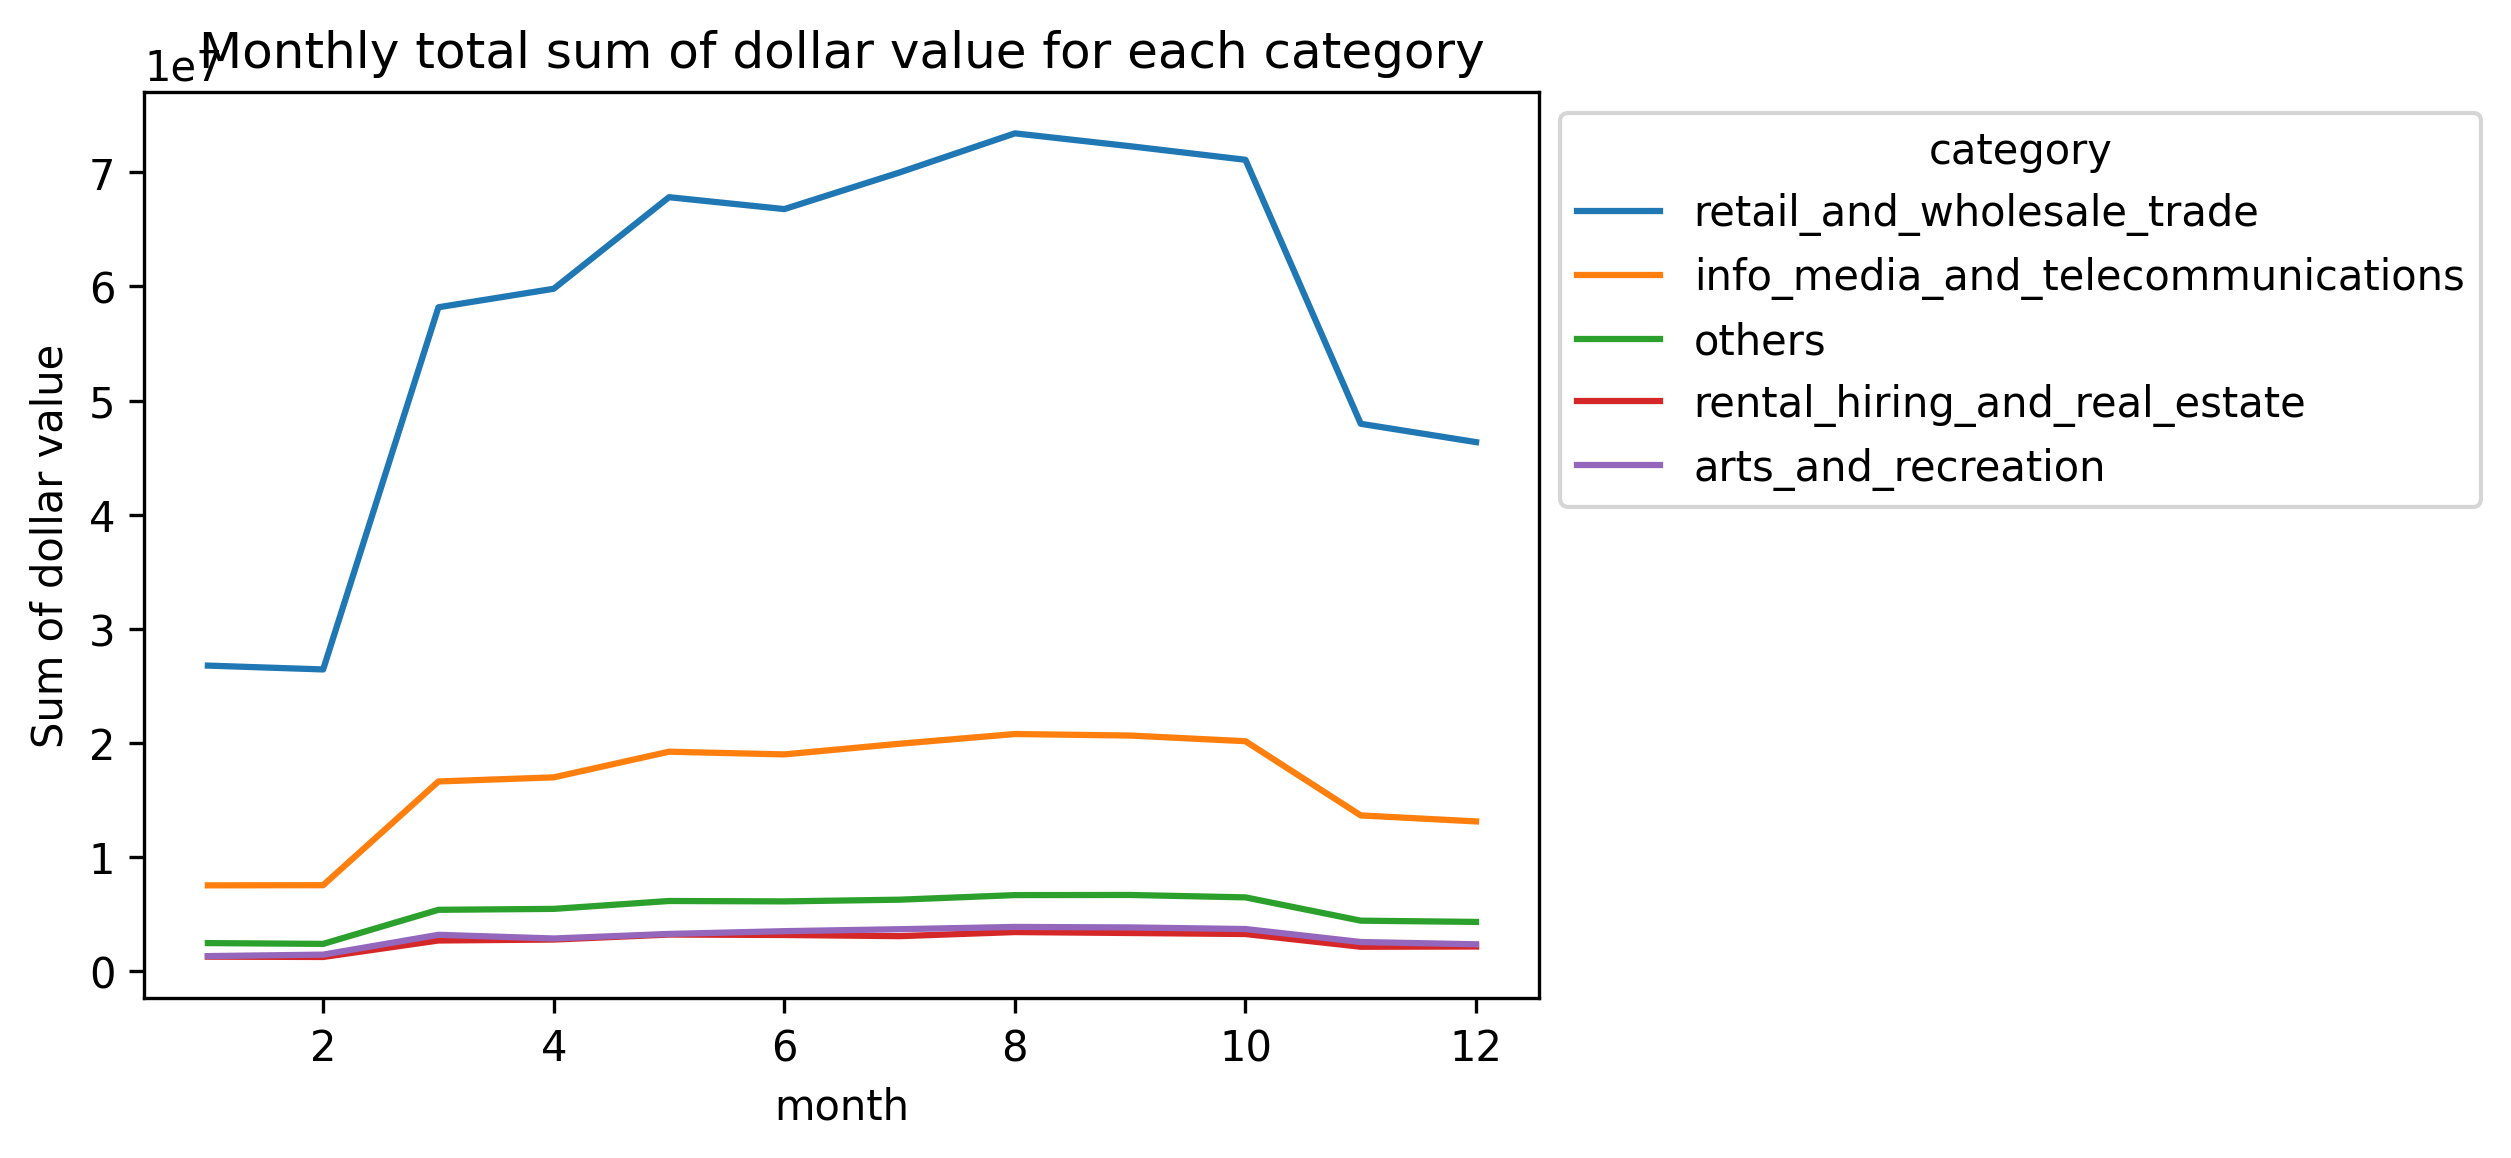

In [32]:
# aggregate
category_monthly = final_dataset.withColumn('month', F.month(final_dataset.order_datetime)).groupBy('category', 'month').sum('dollar_value')

# plot results
ax = sns.lineplot(data= category_monthly.toPandas(), x= 'month', y= 'sum(dollar_value)', hue= 'category')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Monthly total sum of dollar value for each category')
plt.ylabel('Sum of dollar value')

### 4. Monthly sum of dollar value for each subcategory

Text(0, 0.5, 'Sum of dollar value')

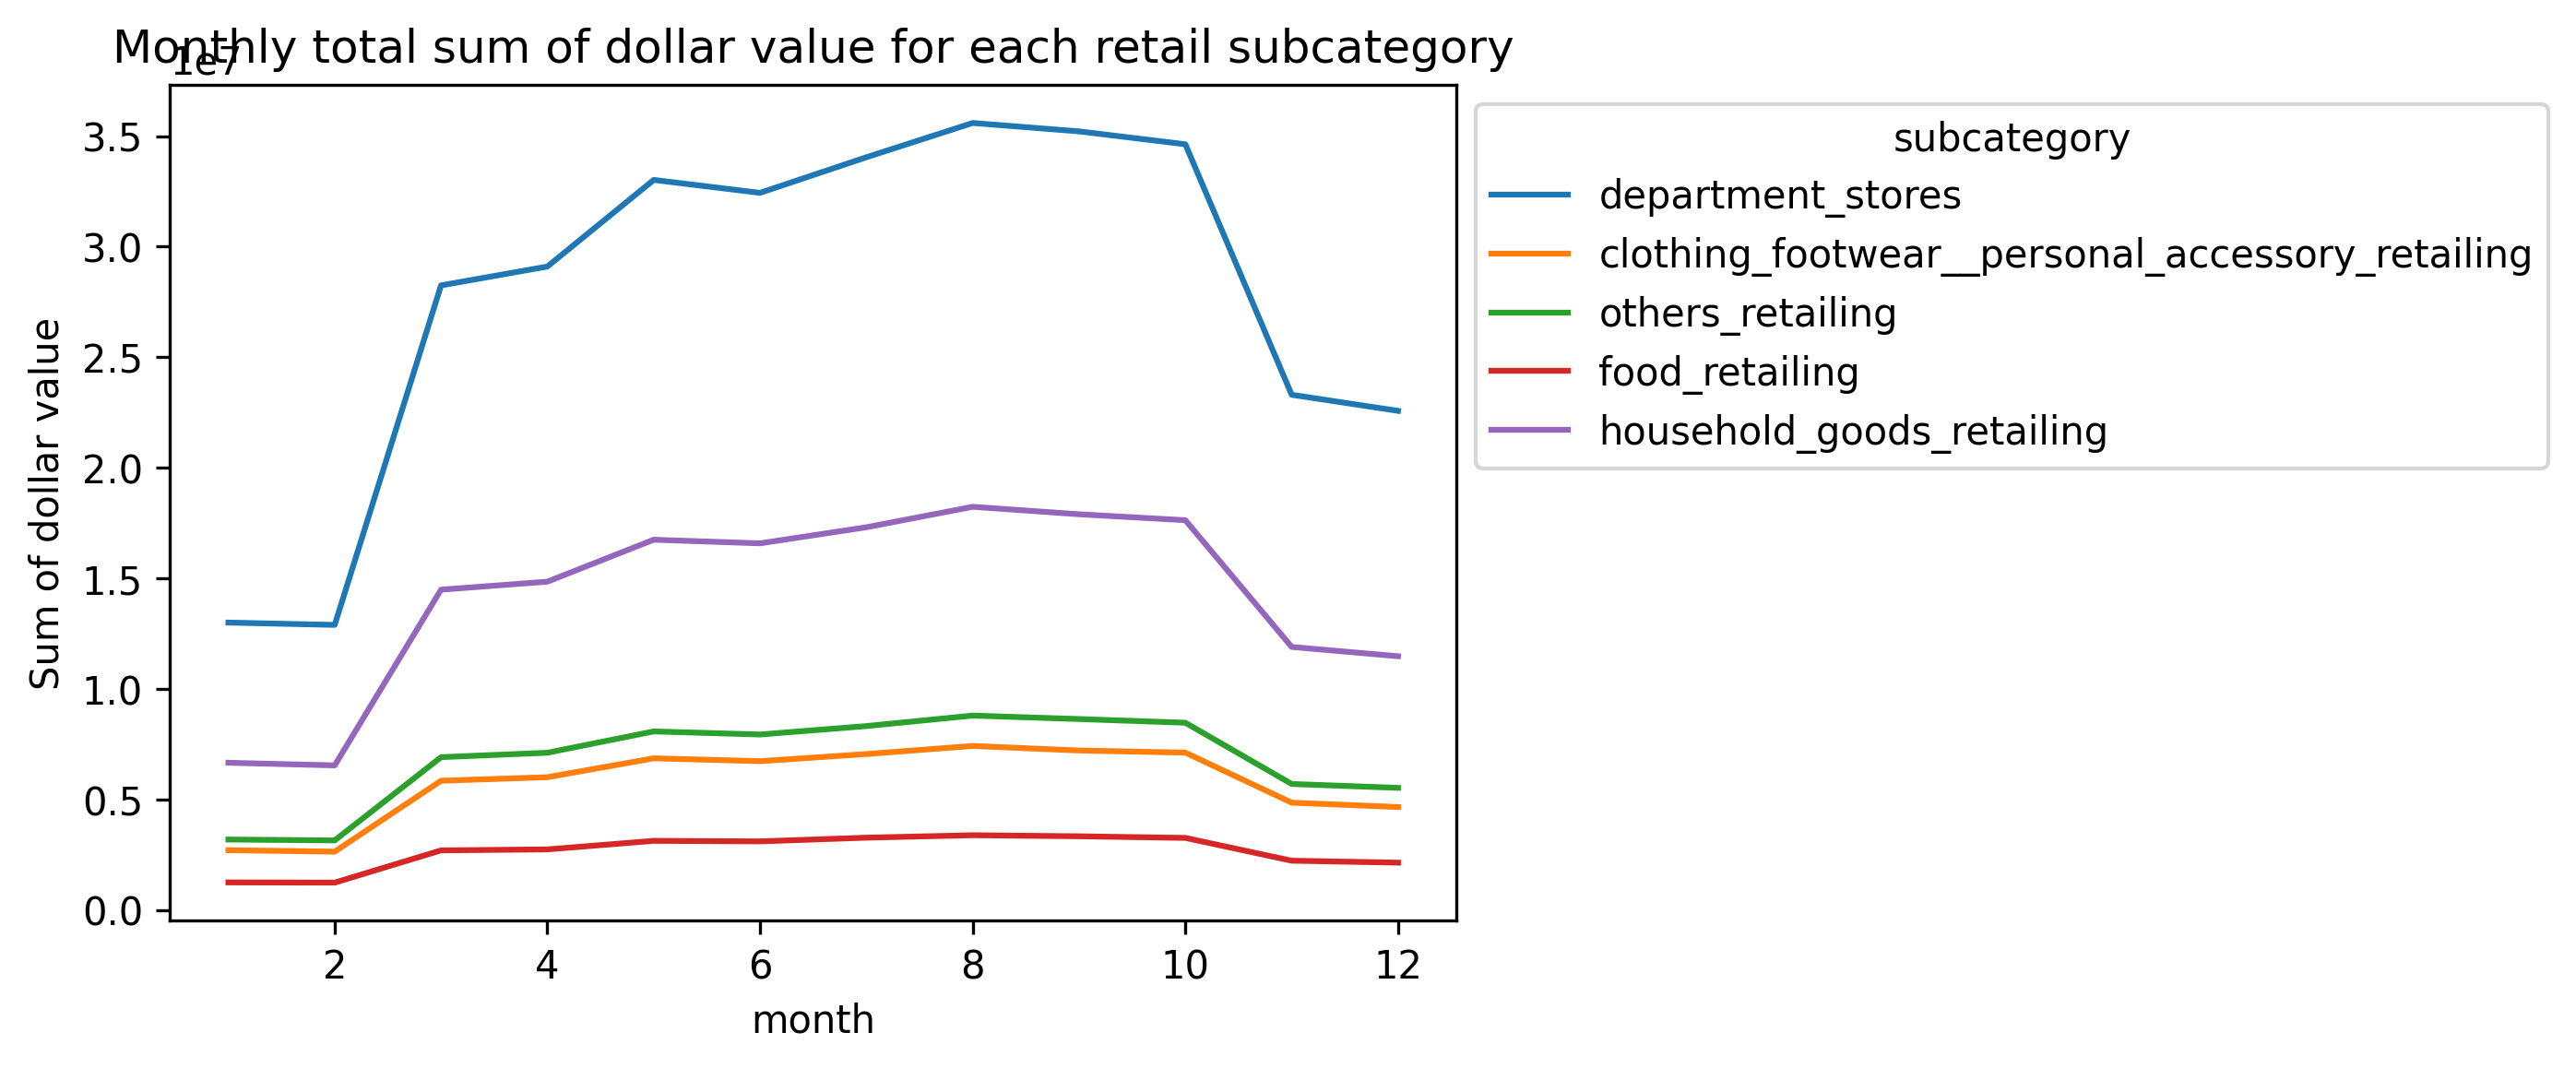

In [33]:
# aggregrate
subcategory_monthly = final_dataset.withColumn('month', F.month(final_dataset.order_datetime)).groupBy('subcategory', 'month').sum('dollar_value')
subcategory_monthly = subcategory_monthly.na.drop()

# plot results
ax1 = sns.lineplot(data= subcategory_monthly.toPandas(), x= 'month', y= 'sum(dollar_value)', hue= 'subcategory')
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
plt.title('Monthly total sum of dollar value for each retail subcategory')
plt.ylabel('Sum of dollar value')

### 5. Sum of dollar value for each category state wise

Text(0, 0.5, 'Sum of dollar value')

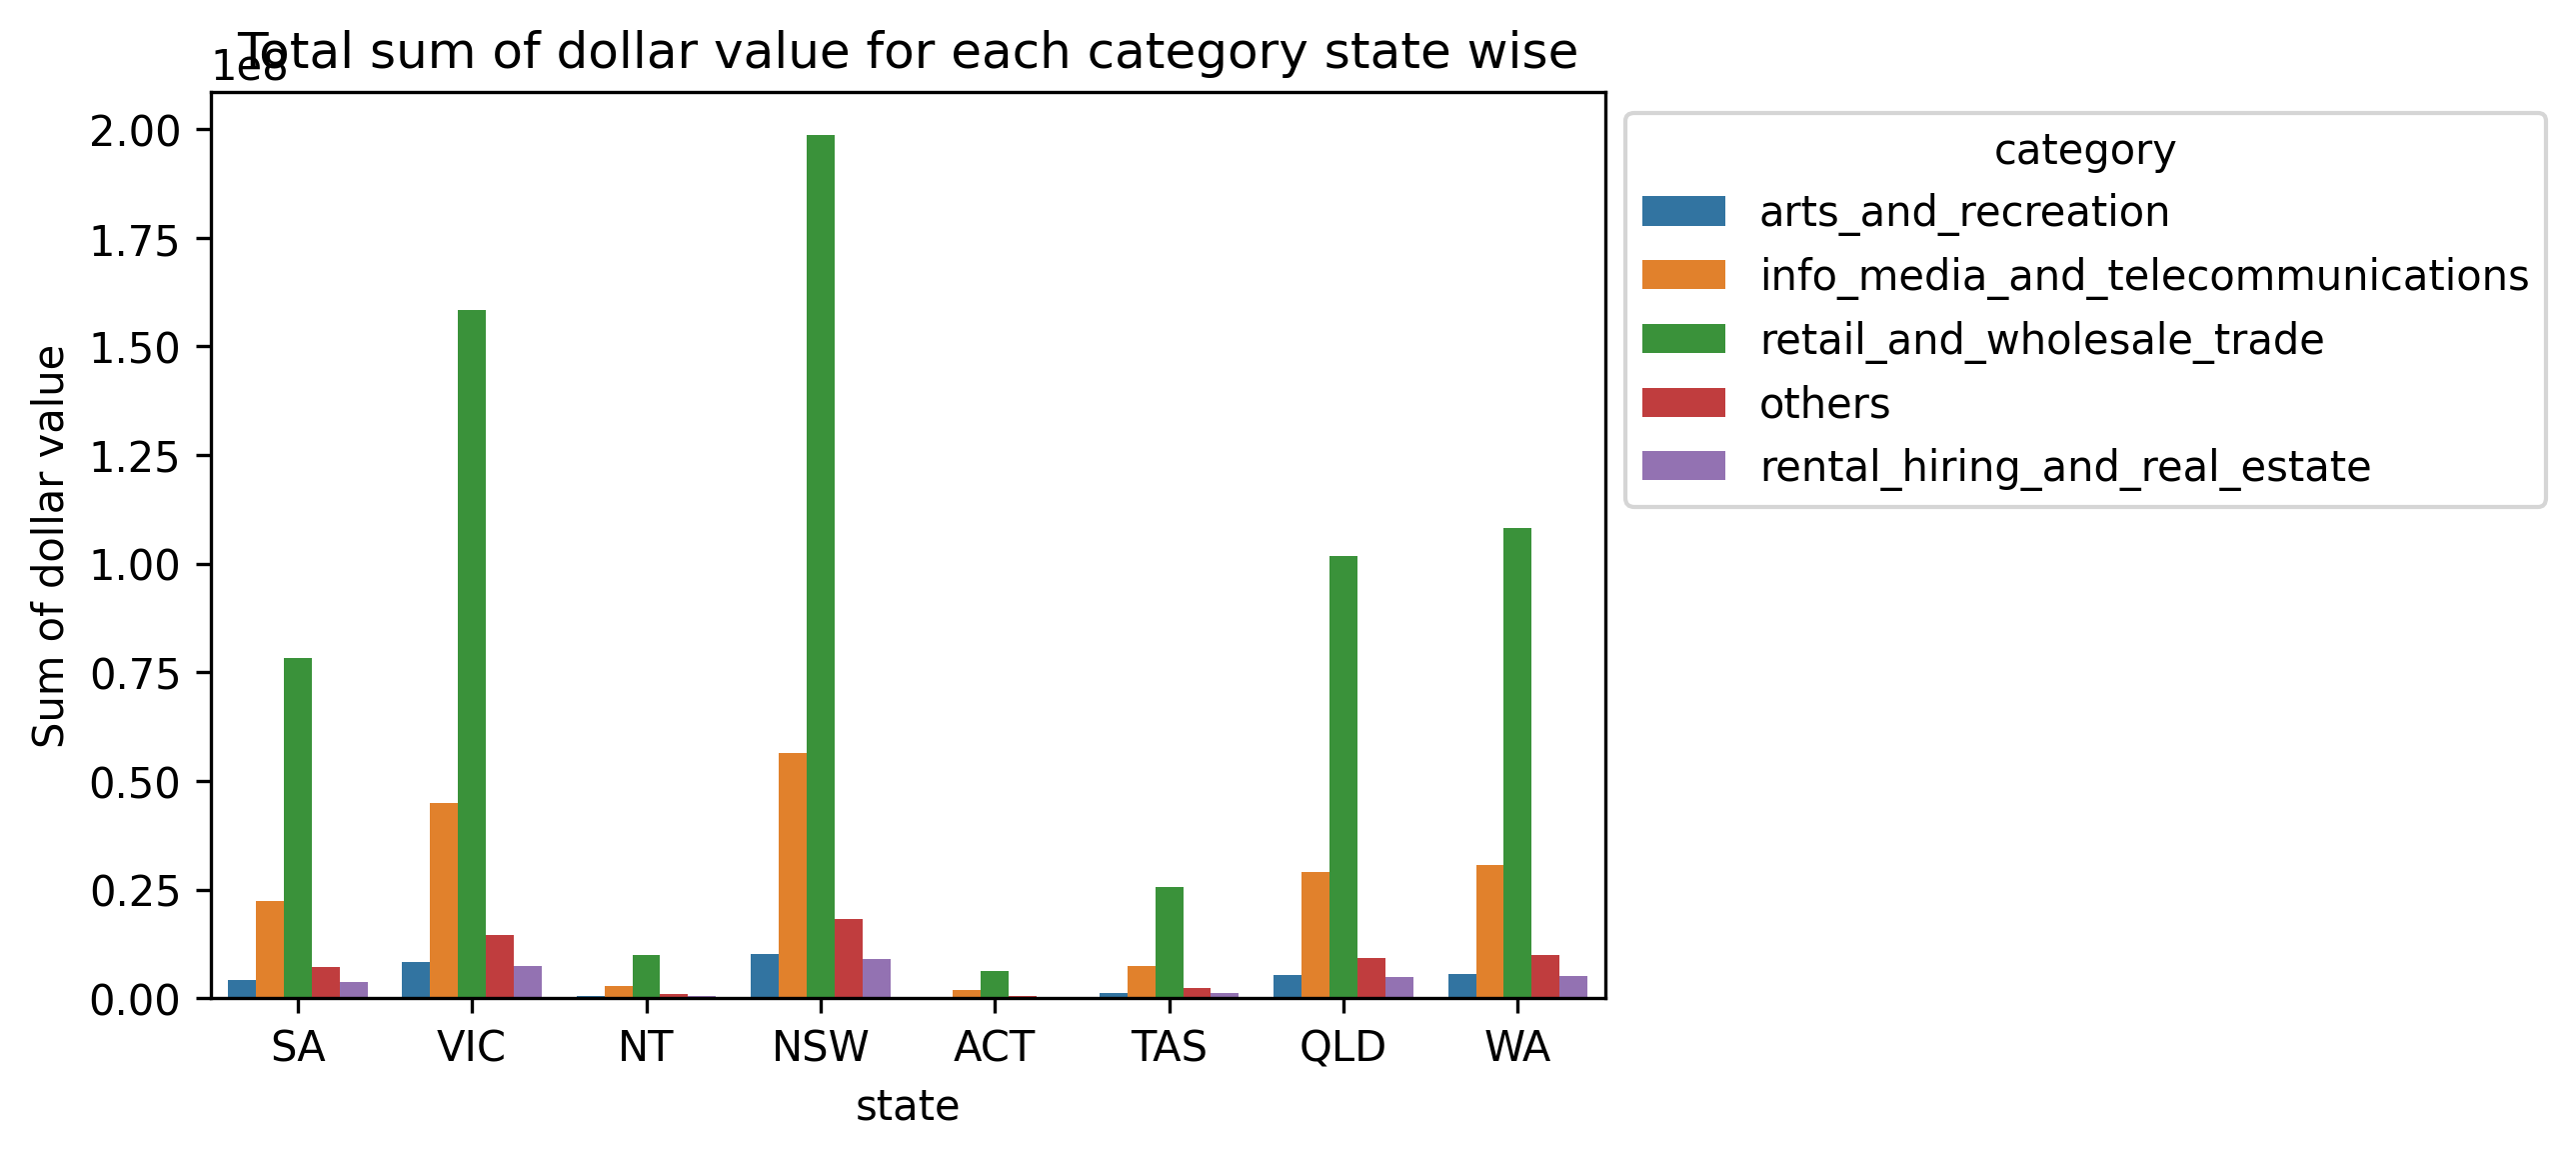

In [34]:
# aggregate
state_category = final_dataset.groupBy('category', 'state').sum('dollar_value')

# plot results
ax2 = sns.barplot(data= state_category.toPandas(), x= "state", y= "sum(dollar_value)", hue= "category")
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))
plt.title('Total sum of dollar value for each category state wise')
plt.ylabel('Sum of dollar value')

### 6. Sum of dollar value for each subcategory state wise

Text(0, 0.5, 'Sum of dollar value')

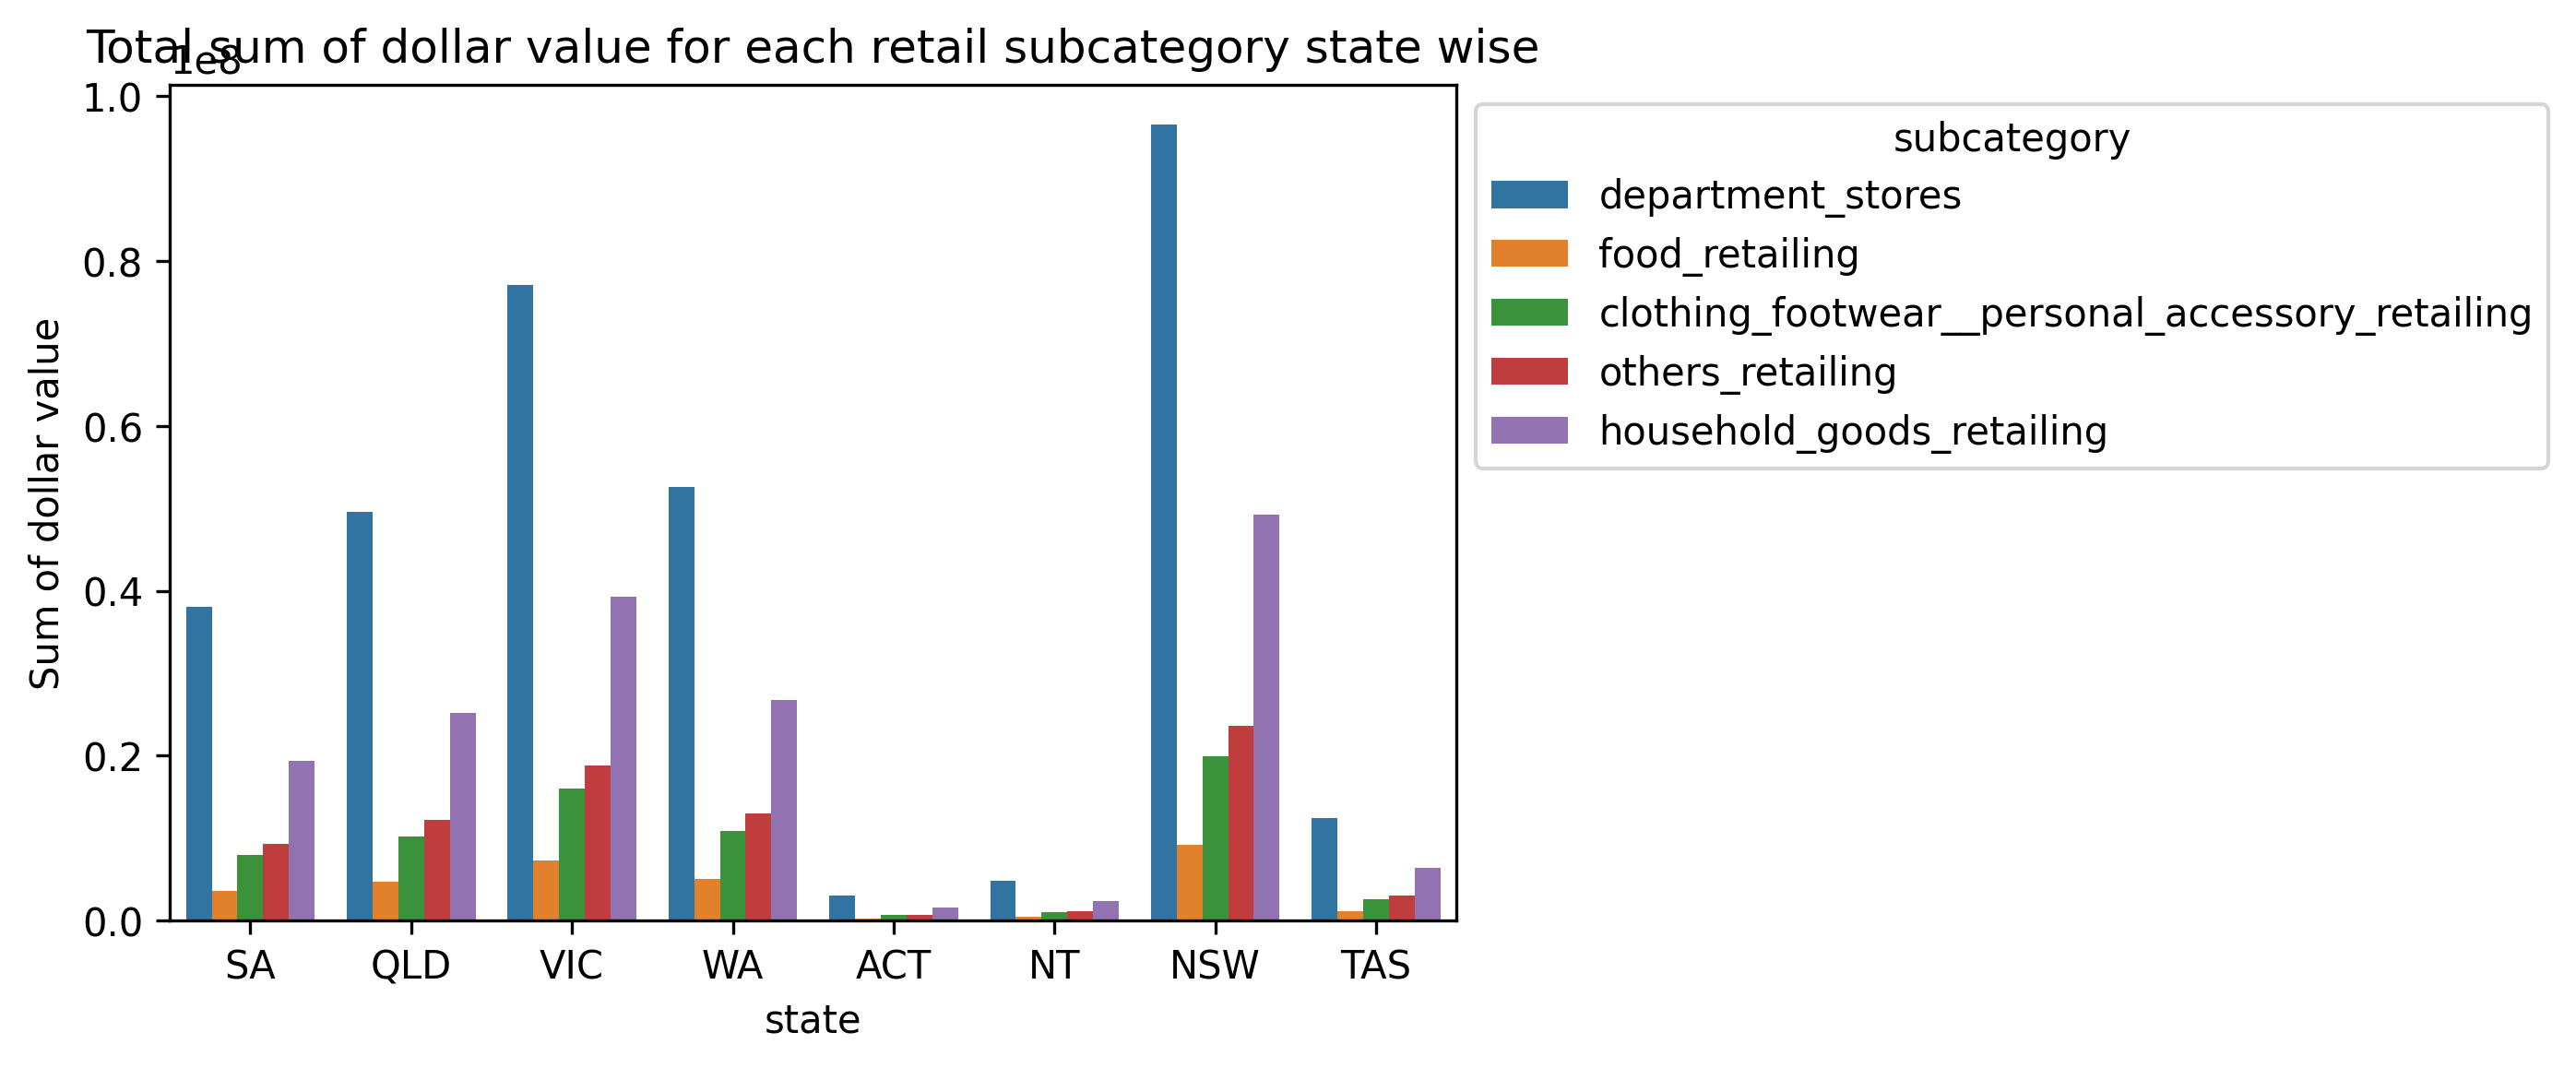

In [35]:
# aggreagate
state_subcategory = final_dataset.groupBy('subcategory', 'state').sum('dollar_value')

# plot results
ax3 = sns.barplot(data= state_subcategory.toPandas(), x= "state", y= "sum(dollar_value)", hue= "subcategory")
sns.move_legend(ax3, "upper left", bbox_to_anchor=(1, 1))
plt.title('Total sum of dollar value for each retail subcategory state wise')
plt.ylabel('Sum of dollar value')

## Ranking

After outlier analysis and detection of fraud transactions, the dataset is now ready for ranking.

To rank the merchants, the expected revenue of each merchant is calculated. This is done by summing up the dollar value of all non-fraud transactions of a merchant, and then multiplying it by the merchant's take rate.

In addition, the standard deviation of the dollar value of all the transactions of each merchant is calculated. It is then multiplied by the take rate. This will measure the risk of the transactions of each merchant. A high standard deviation means that their sales are highly varied and therefore a partnership with this particular merchant may be risky.

Finally, the number of transactions of each merchant is also used to rank them. This is used to measure the confidence of the information about the merchant.

These three features (revenue, risk and confidence) will be used to separate merchants that should or should not be accepted. 

The merchants are ranked by number of transactions in descending order, expected revenue in descending order, and standard deviation/risk in ascending order.

This ranking method is chosen because the main goal of the BNPL firm would be to maximise its profits while reducing risk. This can be done by choosing the highest ranking merchants.

The ranking system gives the following ranking of merchants:

In [36]:
# rank merchants
fullSdf = sdf.groupBy('merchant_name').agg(
        F.sum('dollar_value').alias('income_total'),
        F.stddev('dollar_value').alias('income_deviation'),
        F.mean('rate').alias('rate'),
        F.count('merchant_name').alias('count_merchant'))\
    .withColumn('income_total', F.col('income_total') * F.col('rate'))\
    .withColumn('income_deviation', F.col('income_deviation') * F.col('rate'))\
    .orderBy(F.col('count_merchant').desc(), F.col('income_total').desc(), F.col('income_deviation').asc())

fullSdf

merchant_name,income_total,income_deviation,rate,count_merchant
Erat Vitae LLP,255744.12288606926,0.6226536011043147,0.029400000000007927,289513
Leo In Consulting,613410.4864420289,1.593113297793779,0.06430000000000285,272674
Pede Nonummy Corp.,215914.12099392328,0.42972173195212765,0.0285999999999898,260780
Non Vestibulum In...,415952.5372599552,0.8708643592186126,0.057999999999993584,247526
Suspendisse Dui C...,206349.62331805262,0.8804237642012439,0.029300000000007494,234397
Lacus Consulting,585975.3666878963,2.5631389491234104,0.06979999999998758,228219
Est Nunc Consulting,535420.1324838321,1.4298403330439586,0.06009999999998119,215963
Lorem Ipsum Sodal...,400180.8302160726,1.1563216033026031,0.04470000000000809,199718
Ipsum Dolor Sit C...,106133.55576602687,0.5410840739272169,0.014700000000003686,196816
Vehicula Pellente...,285260.5317600984,1.5744092874770688,0.06480000000002235,181841


Ranking of merchants for each of the 5 categories is shown below:

In [37]:
def topNmerchants(sdf, categories, N):
    '''
    ranks the top N merchants for each of the specified categories
    '''
    
    merchants = {}
    income_total = {}
    income_risk = {}
    counts = {}

    for category in categories:
        tdf = sdf.where(F.col('category') == category)
        tdf = tdf.groupBy('merchant_name').agg(
            F.sum('dollar_value').alias('income_total'),
            F.stddev('dollar_value').alias('income_deviation'),
            F.mean('rate').alias('rate'),
            F.count('merchant_name').alias('count_merchant'))\
        .withColumn('income_total', F.col('income_total') * F.col('rate'))\
        .withColumn('income_deviation', F.col('income_deviation') * F.col('rate'))\
        .orderBy(F.col('count_merchant').desc(), F.col('income_total').desc(), F.col('income_deviation').asc())\
        
        tdf = tdf.limit(N)

        merchants[category] = tdf.select('merchant_name').toPandas()['merchant_name'].to_list()
        
        # assuming that all income is Normally distributed
        income_total[category] = tdf.agg({'income_total': 'sum'}).first()['sum(income_total)']
        income_risk[category] = tdf.agg({'income_deviation': 'sum'}).first()['sum(income_deviation)']
        counts[category] = tdf.agg({'count_merchant': 'sum'}).first()['sum(count_merchant)']

    return pd.DataFrame(merchants), income_total, income_risk, counts

categories = ['retail_and_wholesale_trade', 'rental_hiring_and_real_estate', 'arts_and_recreation', 'info_media_and_telecommunications', 'others']

merchants, total, risk, counts = topNmerchants(sdf, categories, N=10)
merchants

,retail_and_wholesale_trade,rental_hiring_and_real_estate,arts_and_recreation,info_media_and_telecommunications,others
0,Erat Vitae LLP,Quis Massa Mauris Corporation,Magna Sed Industries,Mauris Non Institute,Nec Tellus Ltd
1,Leo In Consulting,Quam A Felis Incorporated,Ac Urna Consulting,Euismod In Corp.,Tempus Eu Ligula Limited
2,Pede Nonummy Corp.,Vel Lectus Cum LLC,Mi Consulting,Feugiat Sed Nec Institute,Sed Nec Inc.
3,Non Vestibulum Industries,Iaculis Enim Corp.,Lorem LLP,Amet Consulting,Natoque Consulting
4,Suspendisse Dui Corporation,Leo Morbi Limited,Volutpat Ornare Facilisis Associates,Arcu Sed Eu Incorporated,Gravida Praesent Corp.
5,Lacus Consulting,Laoreet Inc.,Ligula Tortor Incorporated,Eleifend PC,Mauris Sagittis Corp.
6,Est Nunc Consulting,Massa Limited,Nullam Scelerisque Ltd,Posuere Cubilia Curae Corporation,Nisl Elementum Ltd
7,Lorem Ipsum Sodales Industries,Mi Eleifend Company,Massa LLP,At Sem Corp.,Molestie Arcu Corporation
8,Ipsum Dolor Sit Corporation,Fermentum Institute,Non Cursus LLP,Et Nunc Consulting,Feugiat Lorem Incorporated
9,Vehicula Pellentesque Corporation,Morbi Non Corp.,Mollis Duis Sit Foundation,Suspendisse Incorporated,Risus Odio Auctor Foundation


## Additional Insights

There are some notable merchants that might be worth considering.

In [38]:
# number of transactions for each merchant
numtransaction = sdf.groupBy("merchant_name").count().toPandas()

# total dollar value for each merchant
dollarvalue = sdf.groupBy("merchant_name").sum("dollar_value").toPandas()

# number of different customers for each merchant
numconsumer = sdf.groupBy("merchant_name").agg(F.countDistinct("consumer_id")).toPandas()

# mean dollar value of transaction for each merchant
meandollarvalue = sdf.groupBy("merchant_name").mean("dollar_value").toPandas()

# mean merchant fraud probability of each merchant
meanfraud = sdf.groupBy("merchant_name").mean("merchant_fraud_probability").toPandas()
meanfraud["avg(merchant_fraud_probability)"] = meanfraud["avg(merchant_fraud_probability)"].fillna(0)

# join all dataframes
merchantdf = numtransaction.merge(dollarvalue, on="merchant_name")
merchantdf = merchantdf.merge(numconsumer, on="merchant_name")
merchantdf = merchantdf.merge(meandollarvalue, on="merchant_name")
merchantdf = merchantdf.merge(meanfraud, on="merchant_name")

1. There are some merchants with only a few transactions

The firm might want to exclude these merchants due to lack of information.
The table below shows merchants with only one transaction.

In [39]:
merchantdf.loc[merchantdf["count"] == 1][["merchant_name", "count"]]

,merchant_name,count
316,Felis Ltd,1
3923,Iaculis Quis LLC,1
3982,Elit Dictum Eu Foundation,1
4005,Phasellus LLP,1
4016,Sem Corporation,1
4018,Curae Foundation,1


2. There are some merchants with a very small consumer base

No matter how high the dollar value is, this is not ideal. Having only one or two customer means that the merchant is definitely not doing well. Therefore the firm might want to exclude these merchants from consideration. The table below shows merchants with only one customer.

In [40]:
merchantdf.loc[merchantdf["count(consumer_id)"] == 1][["merchant_name", "count(consumer_id)"]]

,merchant_name,count(consumer_id)
316,Felis Ltd,1
3923,Iaculis Quis LLC,1
3982,Elit Dictum Eu Foundation,1
4005,Phasellus LLP,1
4016,Sem Corporation,1
4018,Curae Foundation,1


3. Merchant with high mean merchant fraud probability

The firm might want to completely remove these merchants from the ranking, instead of removing their fraud transactions, since the merchant is deemed to be untrustworthy. The table shows the 5 merchants with the highest fraud probability.

In [41]:
merchantdf.sort_values(by = "avg(merchant_fraud_probability)", inplace = True, ascending = False)
merchantdf.head(5)[["merchant_name", "avg(merchant_fraud_probability)"]]

,merchant_name,avg(merchant_fraud_probability)
218,Ut Industries,0.73
3127,Mi Eleifend Egestas LLP,0.71
1804,Nullam Enim Sed Incorporated,0.69
1412,Tincidunt Nibh LLP,0.68
403,Nec Limited,0.68


In conclusion, the firm should consider whether the merchants stated above should be excluded from consideration. The decision will depend on whether the firm is willing to take on riskier partnerships in exchange for a possibility of a higher revenue.

## Limitations, Assumptions Difficulties

- Gradient Boosted Tree may be hard to interpret. It is also prone to overfitting/bias if there is an imbalanced dataset.
- Merchants with similar names (for example: Massa Limited and Massa LLP) are assumed to be different, unrelated merchants.
- There are postcodes with multiple corresponding SA2 districts, and SA2 districts with multiple corresponding postcodes. In case there are multiple matches, only one of them is used.
- For the ranking system, dollar value is assumed to be normally distributed.
- When categorizing merchants based on their tags, there are some tags that can correspond to multiple categories.

## Conclusion and Recommendations

The firm should use the ranking of merchants as a guide when selecting merchants to be partnered in the BNPL program. If the firm wants to have partners from a varied set of industries, they can use the ranking of merchants in the 5 different categories to identify the best subset of merchants from each of the 5.

From our selection of merchants from all categories, we can calculate our long term daily average merchant income to be as follows with 3 standard deviations.

Since dollar value is assumed to be *Normally Distributed*, the distribution of the total income per category is also *Normally Distributed* with its parameters being the sum of the selected merchant's dollar_value.

$$
m_1 \sim N(\mu_{1}, \sigma^2_{1}), \dots, m_{10} \sim N(\mu_{10}, \sigma^2_{10}) \\
\implies \sum_{i=1}^{10}m_i \sim N\left(\sum_{i=1}^{10} \mu_i, \sum_{i=1}^{10} \sigma^2_i\right)
$$

We use this to find the daily average income and our 3 standard deviations as found below,

In [42]:
# count total number of days
days = sdf.select('order_datetime').distinct().count()

# calculate mean and standard deviation
mu = sum(total.values()) / days
sigma = sum(risk.values()) / days

# show results
print('Average Daily Income:')
print(f'({mu - (3 * sigma)} <- 3 std - | {mu} | - 3 std -> {mu + (3 * sigma)})')

Average Daily Income:
(13060.268242977081 <- 3 std - | 13065.657473945621 | - 3 std -> 13071.04670491416)


As seen above, the merchants make about \$13066 a day; with \$13060 as lower bound and \$13071 as upper bound.